# Steam Game Recommender

### Business and Data Understanding
**StakeHolder:** Steam

**Business Problem:** Steam wants to enhance user experience and increase engagement by providing personalized game recommendations to its users. The goal is to help users discover new games that they are likely to enjoy, based on their existing preferences and behaviors.

**Problem Statement:** The Steam Game Recommender system aims to predict user ratings for games based on various game features. The dataset is sourced from Kaggle and includes game titles, descriptions, tags, and user ratings. This dataset is well-suited for the business problem as it contains rich textual and numerical data that can be used to understand the characteristics of each game and predict user preferences.

**Data Understanding**

Source: https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam/data?select=recommendations.csv

Context:
The steam games dataset is a dataset of ~ 50,000 games available and over 40 Million reviews on steam. The dataset was collected from the Steam Official Store.

Content: 
- games.csv - a table of games (or add-ons) information on ratings, pricing in US dollars $, release date, etc. A piece of extra non-tabular details on games, such as descriptions and tags, is in a metadata file;
- users.csv - a table of user profiles' public information: the number of purchased products and reviews published;
- recommendations.csv - a table of user reviews: whether the user recommends a product. The table represents a many-many relation between a game entity and a user entity.

**Descriptive Statistics**
- Number of Games: 50,246
- Number of Recommendations: 41,154,794
- Average positive ratio: 77.052033 (0-100)

### Data Preparation
1. Loading the Data:
    - Change dtypes to hold less memory
        - float64 --> float32
        - int64 --> int32
        - object --> category

2. Data Cleaning:
    - Assign proper dtypes to columns
    - Check for missingness and duplicates
    - Handle missing values appropriately
    - Check for outliers
    - Determine correlation matrices

3. Data Transformation:
    - Standardize and tokenize text data (e.g., game descriptions, tags)
    - Label encode categorical data (e.g., ratings, mac, win, linux)

4. Feature Extraction:
    - NLTK to preprocess text
    - Use TF-IDF vectorization for text features
    - Scale positive ratio down to a range of 0-1

Libraries Used:
- pandas for data manipulation
- scikit-learn for text processing, vectorization, and scaling
- NLTK for preprocessing textual columns to find key words
- surprise for model building, searching for best parameters, and cross validation

### Modeling

**Collaborative-Based Filtering**

Utilized the surprise library for its simplicity in model building and tuning. I implemented Baseline, SVD, and KNN models. For Baseline and SVD, I performed a train-test split twice: once to sample the data and another to create train and test sets. For KNN, due to memory constraints, I split the data three times, using the same initial splits as SVD and Baseline, followed by an additional split. I then conducted a grid search to find the optimal hyperparameters for the SVD and KNN models. The Baseline model served as a benchmark for comparison. Model performance was evaluated using RMSE, MAE, Precision@k, and Recall@k.

**Content-Based Filtering**

Used the sklearn library to build this model. I applied TF-IDF vectorization on combined textual features such as title, description, and tags. After splitting the data into train and test sets to assess overfitting or underfitting, I vectorized the combined features using TfidfVectorizer from sklearn. Due to memory limitations, cosine similarity was calculated in batches of 10. The recommended games were evaluated based on RMSE, MAE, Precision@k, and Recall@k.

### Evaluation

Final Model: SVD Collaborative Filtering
- SVD Train RMSE: 0.013, SVD Test RMSE: 0.048
- SVD Train MAE: 0.008, SVD Test MAE: 0.023

The SVD Collaborative Filtering model performed the best out of my 4 models, Baseline, SVD, KNN, and Content Filtering (NLTK, TF-IDF, Cosine Similarity). SVD had the lowest RMSE and MAE metrics. These metrics we want as low as possible to decrease the error found in the recommended games. In my collaborative filtering models all of the models performed really well on the precision at k and recall at k scores, but this is due to the original dataset being skewed towards the higher end on the graph. Thus, focusing on the RMSE and MAE metrics.

## Importing the Datasets

In [105]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, SVD, accuracy, KNNBasic, BaselineOnly
from surprise.model_selection import train_test_split as surprise_train_test_split, GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split as sklearn_train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import defaultdict

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

# Download NLTK resources
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Brian\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Brian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Brian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Function to reduce the memory usage of a DataFrame.
def reduce_memory(df):
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
        elif df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
        elif df[col].dtype == 'object':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')
    return df

# Function to read and process CSV in chunks
def read_and_reduce_csv(file_path, chunksize=10000):
    chunks = pd.read_csv(file_path, chunksize=chunksize)
    df_list = [reduce_memory(chunk) for chunk in chunks]
    return pd.concat(df_list, ignore_index=True)

In [3]:
# Reading and reducing memory usage for CSV files
games = read_and_reduce_csv('../data/raw/games.csv')
recommendations = read_and_reduce_csv('../data/raw/recommendations.csv')
users = read_and_reduce_csv('../data/raw/users.csv')

# Reading and reducing memory usage for JSON files
games_metadata = pd.read_json('../data/raw/games_metadata.json')

Reduce the size of the columns when loading to save memory for running code later

## A look at the Datasets

In [4]:
games

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50867,2296380,I Expect You To Die 3: Cog in the Machine,2023-09-28,True,False,False,Very Positive,96,101,22.00,0.00,0.0,True
50868,1272080,PAYDAY 3,2023-09-21,True,False,False,Mostly Negative,38,29458,40.00,0.00,0.0,True
50869,1402110,Eternights,2023-09-11,True,False,False,Very Positive,89,1128,30.00,0.00,0.0,True
50870,2272250,Forgive Me Father 2,2023-10-19,True,False,False,Very Positive,95,82,17.00,0.00,0.0,True


In [5]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   app_id          50872 non-null  int32  
 1   title           50872 non-null  object 
 2   date_release    50872 non-null  object 
 3   win             50872 non-null  bool   
 4   mac             50872 non-null  bool   
 5   linux           50872 non-null  bool   
 6   rating          50872 non-null  object 
 7   positive_ratio  50872 non-null  int32  
 8   user_reviews    50872 non-null  int32  
 9   price_final     50872 non-null  float32
 10  price_original  50872 non-null  float32
 11  discount        50872 non-null  float32
 12  steam_deck      50872 non-null  bool   
dtypes: bool(4), float32(3), int32(3), object(3)
memory usage: 2.5+ MB


In [6]:
games.describe()

,app_id,positive_ratio,user_reviews,price_final,price_original,discount
count,5.087200e+04,50872.000000,5.087200e+04,50872.000000,50872.000000,50872.000000
mean,1.055224e+06,77.052033,1.824425e+03,8.620325,8.726789,5.592212
std,6.103249e+05,18.253592,4.007352e+04,11.514519,11.506458,18.605179
min,1.000000e+01,0.000000,1.000000e+01,0.000000,0.000000,0.000000
25%,5.287375e+05,67.000000,1.900000e+01,0.990000,0.990000,0.000000
50%,9.860850e+05,81.000000,4.900000e+01,4.990000,4.990000,0.000000
75%,1.524895e+06,91.000000,2.060000e+02,10.990000,11.990000,0.000000
max,2.599300e+06,100.000000,7.494460e+06,299.989990,299.989990,90.000000


In [7]:
games_metadata

,app_id,description,tags
0,13500,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
1,22364,,[Action]
2,113020,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
3,226560,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."
4,249050,Dungeon of the Endless is a Rogue-Like Dungeon...,"[Roguelike, Strategy, Tower Defense, Pixel Gra..."
...,...,...,...
50867,2296380,,[]
50868,1272080,,[]
50869,1402110,,[]
50870,2272250,Embark on a journey into the darkest nightmare...,"[Early Access, FPS, Action, Retro, First-Perso..."


In [8]:
games_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50872 entries, 0 to 50871
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   app_id       50872 non-null  int64 
 1   description  50872 non-null  object
 2   tags         50872 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [9]:
games_metadata.describe()

,app_id
count,5.087200e+04
mean,1.055224e+06
std,6.103249e+05
min,1.000000e+01
25%,5.287375e+05
50%,9.860850e+05
75%,1.524895e+06
max,2.599300e+06


In [10]:
recommendations

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.299999,51580,0
1,304390,4,0,2017-02-17,False,11.500000,2586,1
2,1085660,2,0,2019-11-17,True,336.500000,253880,2
3,703080,0,0,2022-09-23,True,27.400000,259432,3
4,526870,0,0,2021-01-10,True,7.900000,23869,4
...,...,...,...,...,...,...,...,...
41154789,633230,0,0,2021-02-15,True,41.000000,1606890,41154789
41154790,758870,8,0,2019-07-18,False,8.000000,1786254,41154790
41154791,696170,3,10,2018-03-26,False,2.000000,6370324,41154791
41154792,696170,0,0,2018-06-11,True,4.000000,1044289,41154792


In [11]:
recommendations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41154794 entries, 0 to 41154793
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int32  
 1   helpful         int32  
 2   funny           int32  
 3   date            object 
 4   is_recommended  bool   
 5   hours           float32
 6   user_id         int32  
 7   review_id       int32  
dtypes: bool(1), float32(1), int32(5), object(1)
memory usage: 1.3+ GB


In [12]:
recommendations.describe()

,app_id,helpful,funny,hours,user_id,review_id
count,4.115479e+07,4.115479e+07,4.115479e+07,4.115479e+07,4.115479e+07,4.115479e+07
mean,6.032724e+05,3.202567e+00,1.058071e+00,1.006022e+02,7.450576e+06,2.057740e+07
std,4.729233e+05,4.693649e+01,2.867060e+01,1.649791e+02,4.010685e+06,1.188037e+07
min,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.539400e+05,0.000000e+00,0.000000e+00,7.800000e+00,4.287256e+06,1.028870e+07
50%,4.351500e+05,0.000000e+00,0.000000e+00,2.730000e+01,7.546446e+06,2.057740e+07
75%,9.331100e+05,0.000000e+00,0.000000e+00,9.920000e+01,1.096877e+07,3.086609e+07
max,2.253290e+06,3.621200e+04,2.810900e+04,1.000000e+03,1.430606e+07,4.115479e+07


In [13]:
users

,user_id,products,reviews
0,7360263,359,0
1,14020781,156,1
2,8762579,329,4
3,4820647,176,4
4,5167327,98,2
...,...,...,...
14306059,5047430,6,0
14306060,5048153,0,0
14306061,5059205,31,0
14306062,5074363,0,0


In [14]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14306064 entries, 0 to 14306063
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int32
 1   products  int32
 2   reviews   int32
dtypes: int32(3)
memory usage: 163.7 MB


In [15]:
users.describe()

,user_id,products,reviews
count,1.430606e+07,1.430606e+07,1.430606e+07
mean,7.153032e+06,1.163734e+02,2.876738e+00
std,4.129805e+06,2.438515e+02,7.987421e+00
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.576516e+06,2.300000e+01,1.000000e+00
50%,7.153032e+06,5.500000e+01,1.000000e+00
75%,1.072955e+07,1.270000e+02,3.000000e+00
max,1.430606e+07,3.221400e+04,6.045000e+03


## Cleaning the Datasets

In [16]:
# converting the date_release column to datetime in the games dataframe
games['date_release'] = pd.to_datetime(games['date_release'])

# converting the date column to datetime in the recommendations dataframe
recommendations['date'] = pd.to_datetime(recommendations['date'])

In [17]:
# Function to check for missing values in a dataset
def missing_values_checker(dataset, dataset_name):
    missing = []
    missing_values = dataset.isnull().sum()
    for column, value in missing_values.items():
        if value > 0:
            missing.append(column)
    
    if len(missing) == 0:
        print(f'No missing values found in {dataset_name}')
    else:
        print(f'Missing values found in {dataset_name} in columns: {missing}')

    return None

In [18]:
missing_values_checker(games, 'games')
missing_values_checker(games_metadata, 'games_metadata')
missing_values_checker(recommendations, 'recommendations')
missing_values_checker(users, 'users')

No missing values found in games
No missing values found in games_metadata
No missing values found in recommendations
No missing values found in users


In [19]:
# Function to check for duplicates in a dataset
def duplicate_checker(dataset, dataset_name):
    duplicates = []
    duplicate_values = dataset.duplicated().sum()
    if duplicate_values > 0:
        duplicates.append(duplicate_values)
    
    if len(duplicates) == 0:
        print(f'No duplicates found in {dataset_name}')
    else:
        print(f'Duplicates found in {dataset_name}: {duplicates}')

# Function to check for duplicates in a dataset for metadata
def metadata_duplicate_checker(dataset, dataset_name):
    # Convert the 'tags' column from list to tuple to make it hashable
    dataset['tags'] = dataset['tags'].apply(tuple)
    
    duplicates = dataset[dataset.duplicated()]
    
    if duplicates.empty:
        print(f'No duplicates found in {dataset_name}')
    else:
        print(f'Duplicates found in {dataset_name}: {len(duplicates)}')
        print(duplicates)
    
    return duplicates

In [20]:
duplicate_checker(games, 'games')
metadata_duplicate_checker(games_metadata, 'games_metadata')
duplicate_checker(recommendations, 'recommendations')
duplicate_checker(users, 'users')

No duplicates found in games
No duplicates found in games_metadata
No duplicates found in recommendations
No duplicates found in users


In [21]:
# Function to check for empty strings in a dataset
def empty_string_checker(dataset, dataset_name):
    empty_strings = []
    for column in dataset.columns:
        empty_string_values = dataset[dataset[column] == '']
        if not empty_string_values.empty:
            empty_strings.append(column)
    
    if len(empty_strings) == 0:
        print(f'No empty strings found in {dataset_name}')
    else:
        print(f'Empty strings found in {dataset_name} in columns: {empty_strings}')

    return None

def empty_list_checker(dataset, dataset_name):
    empty_lists = []
    temp_dataset = dataset.drop(columns=['app_id'])
    for column in temp_dataset.columns:
        empty_list_values = temp_dataset[temp_dataset[column].apply(len) == 0]
        if not empty_list_values.empty:
            empty_lists.append(column)
    
    if len(empty_lists) == 0:
        print(f'No empty lists found in {dataset_name}')
    else:
        print(f'Empty lists found in {dataset_name} in columns: {empty_lists}')

    return None

In [22]:
empty_string_checker(games, 'games')
empty_string_checker(games_metadata, 'games_metadata')
empty_string_checker(recommendations, 'recommendations')
empty_string_checker(users, 'users')
print('\n')
empty_list_checker(games_metadata, 'games_metadata')

No empty strings found in games
Empty strings found in games_metadata in columns: ['description']
No empty strings found in recommendations
No empty strings found in users


Empty lists found in games_metadata in columns: ['description', 'tags']


In [23]:
# Substitue empty strings with "No Description" in the 'description' column of games_metadata
games_metadata['description'] = games_metadata['description'].replace('', 'No Description')

# Substitue empty strings with "No Tags" in the 'tags' column of games_metadata
games_metadata['tags'] = games_metadata['tags'].apply(lambda x: ['No Tags'] if len(x) == 0 else x)

In [24]:
empty_string_checker(games_metadata, 'games_metadata')
empty_list_checker(games_metadata, 'games_metadata')

No empty strings found in games_metadata
No empty lists found in games_metadata


**Review**

There were 2 data types that were misclassified in games and recommendation datasets. The date-to-time was incorrect. These types were changed from objects to date-to-time types.

Generally all of the datasets were clean of missing and duplicated data besides "game_metadata". Game_metadata had empty string and empty lists representing no data for each of the games. To handle this I simply replaced the empty strings, found in description, with "No Description" and replaced the empty list, found in tags, with "[No Tags]". Since the other datasets didn't have any missing or duplicated data, nothing needs to be done with them.

## Outlier Detection

In [27]:
# Function to find outliers in the dataset
def outlier_checker(dataset, dataset_name):
    outliers = []
    for column in dataset.columns:
        if dataset[column].dtype == np.float32 or dataset[column].dtype == np.int32:
            Q1 = dataset[column].quantile(0.25)
            Q3 = dataset[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outlier_values = dataset[(dataset[column] < lower_bound) | (dataset[column] > upper_bound)]
            if not outlier_values.empty:
                outliers.append(column)
    
    if len(outliers) == 0:
        print(f'No outliers found in {dataset_name}')
    else:
        print(f'Outliers found in {dataset_name} in columns: {outliers}')

    return None

In [28]:
outlier_checker(games, 'games')
outlier_checker(games_metadata, 'games_metadata')
outlier_checker(recommendations, 'recommendations')
outlier_checker(users, 'users')

Outliers found in games in columns: ['positive_ratio', 'user_reviews', 'price_final', 'price_original', 'discount']
No outliers found in games_metadata
Outliers found in recommendations in columns: ['app_id', 'helpful', 'funny', 'hours']
Outliers found in users in columns: ['products', 'reviews']


In [31]:
# Function to graph outliers in the dataset
def outlier_grapher(dataset, dataset_name, columns):
    for column in columns:
        if dataset[column].dtype == np.float32 or dataset[column].dtype == np.int32:
            plt.figure(figsize=(10, 5))
            sns.boxplot(x=dataset[column])
            plt.title(f'Boxplot of {column} in {dataset_name}')
            plt.show()

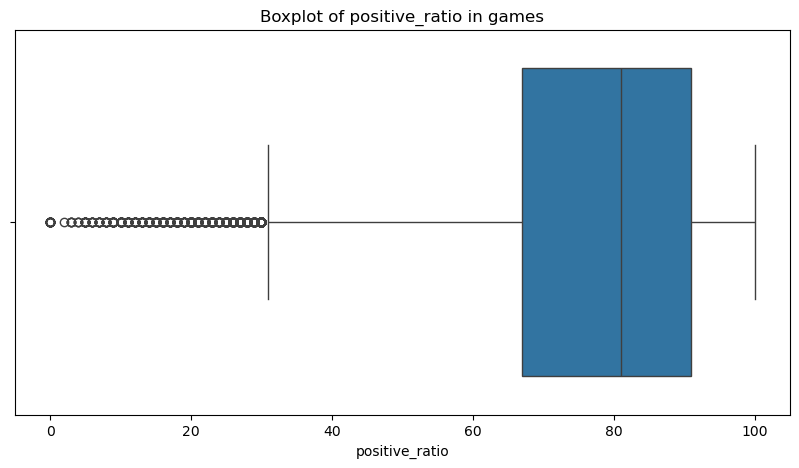

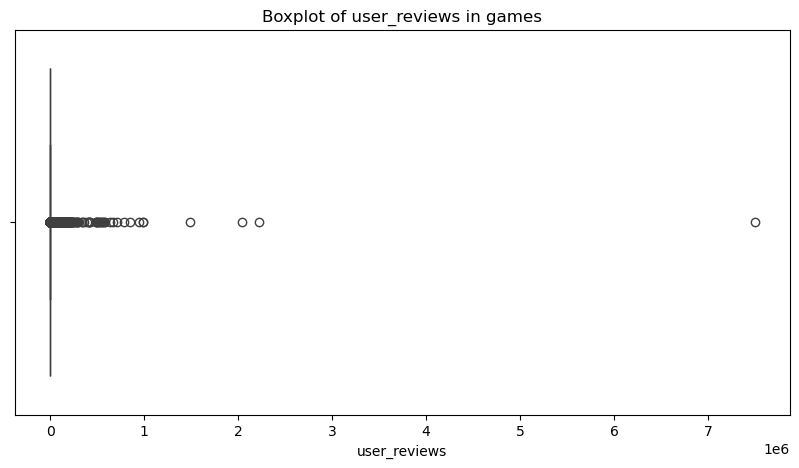

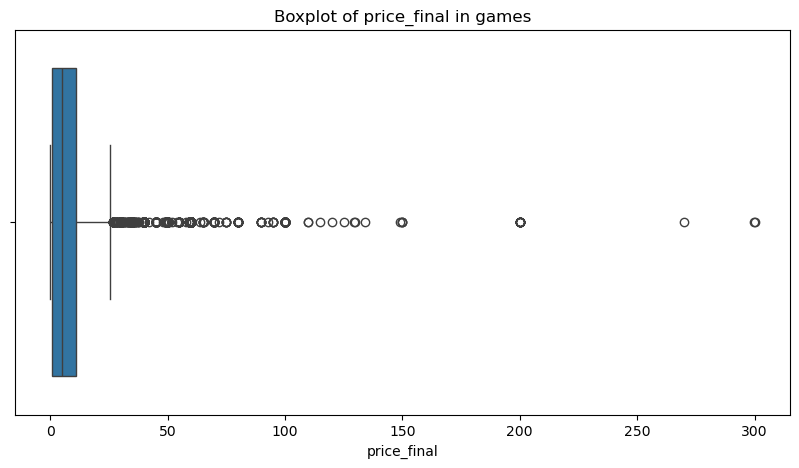

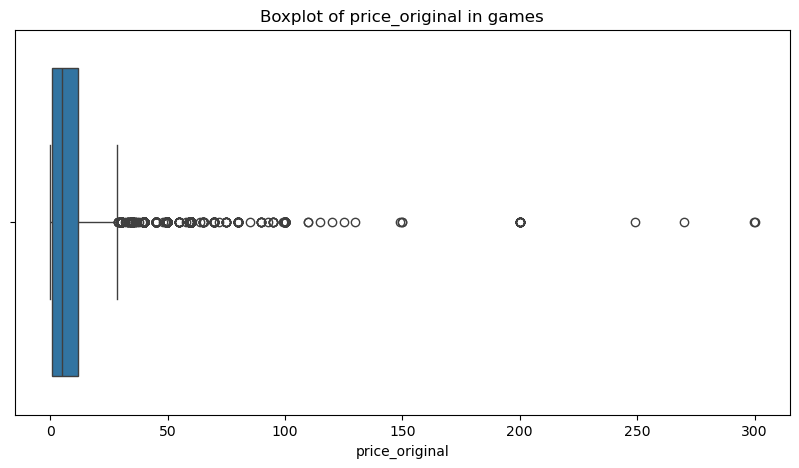

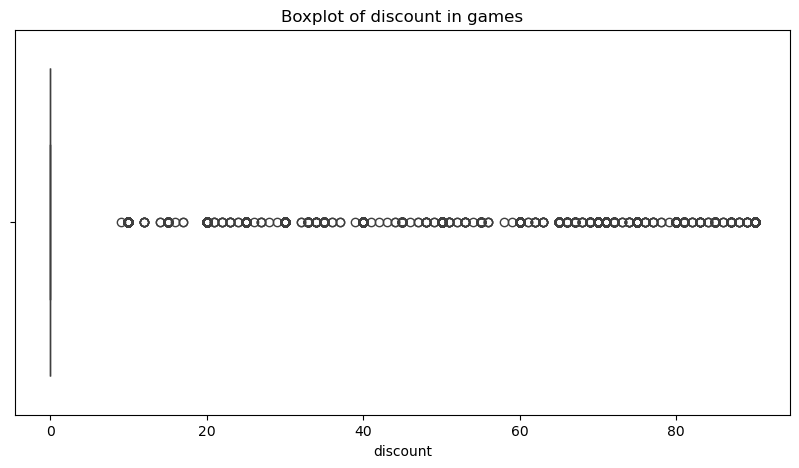

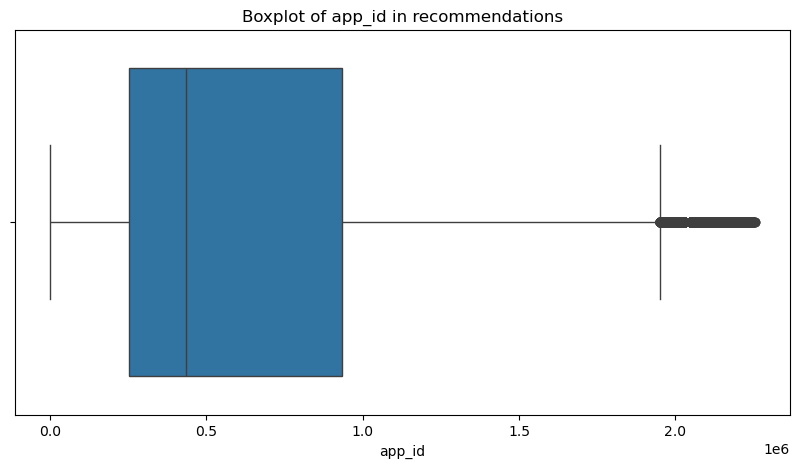

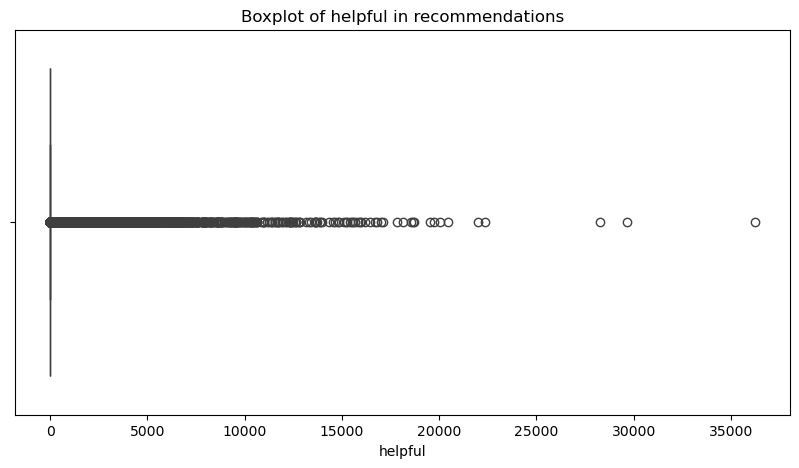

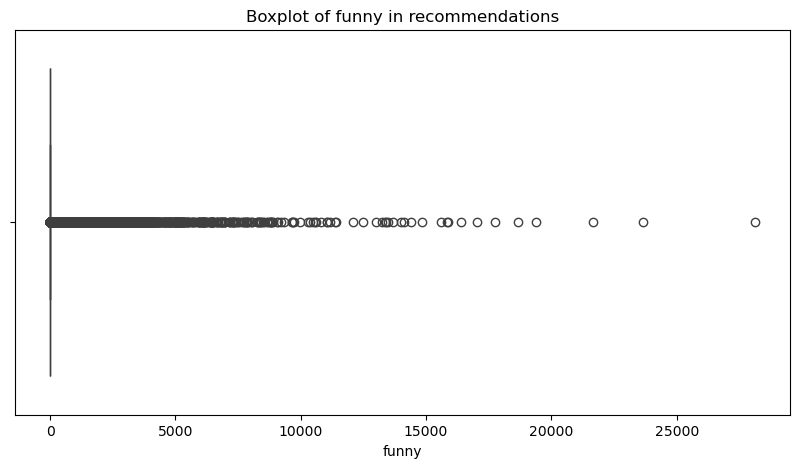

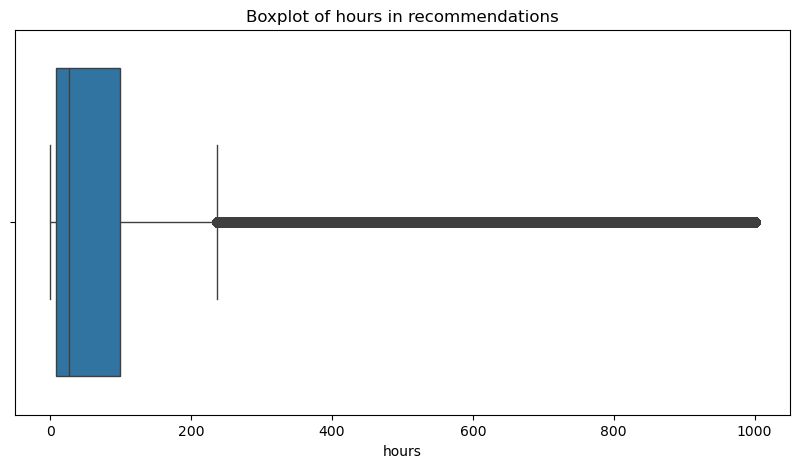

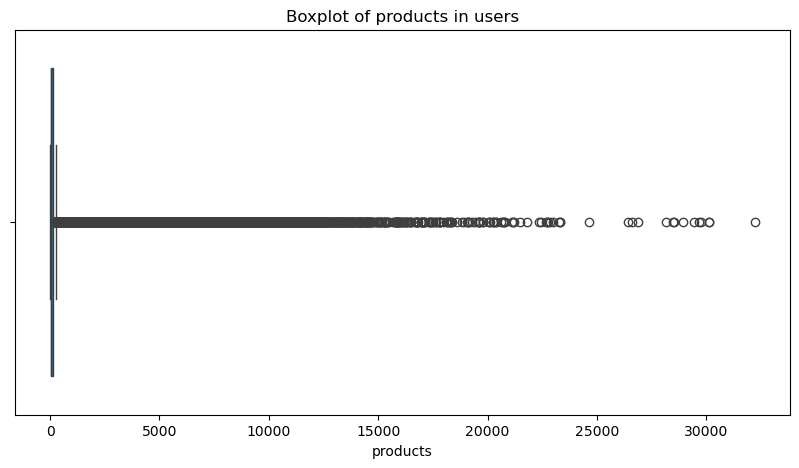

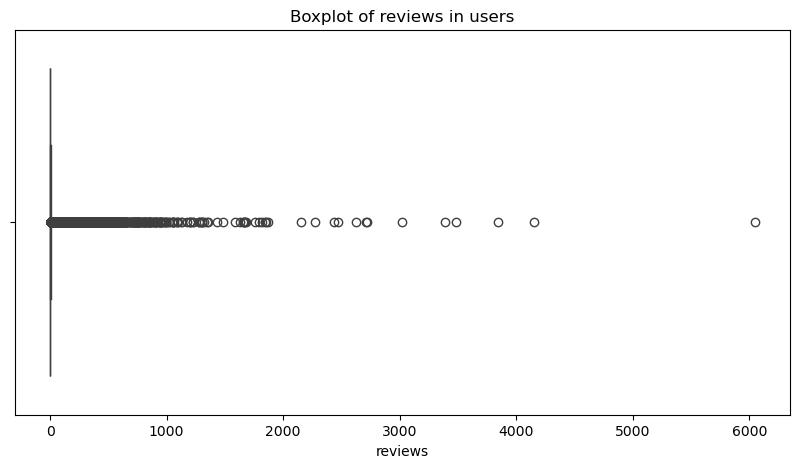

In [32]:
games_outliers = ['positive_ratio', 'user_reviews', 'price_final', 'price_original', 'discount']
recommendations_outliers = ['app_id', 'helpful', 'funny', 'hours']
users_outliers = ['products', 'reviews']

outlier_grapher(games, 'games', games_outliers)
# No outliers found in games_metadata
outlier_grapher(recommendations, 'recommendations', recommendations_outliers)
outlier_grapher(users, 'users', users_outliers)

**Review**

Although outliers were found I decided not to remove any, due to them being natural variations of the data. Removing them could potentially result in a loss of valuable information and insights that are critical for a comprehensive analysis. Additionally, retaining these natural variations ensures that the recommendation system accurately reflects the diversity and range of user behaviors and game attributes present in the real-world data.

## Correlation Matrices

In [33]:
# function for correlation matrix
def correlation_matrix(dataset, dataset_name):
    corr = dataset.corr()
    plt.figure(figsize=(10, 5))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation Matrix of {dataset_name}')
    plt.show()

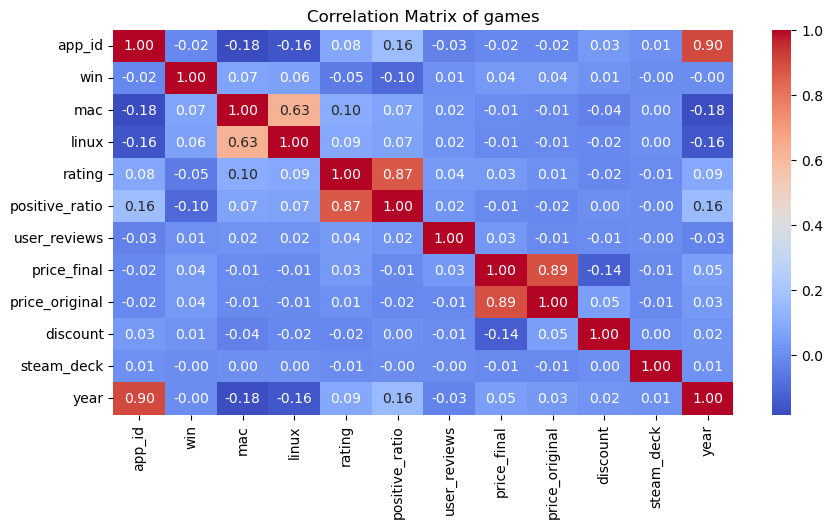

In [122]:
# correlation matrix for games
# Exclude rows where the column contains non-numeric data
games_matrix = games.select_dtypes(include=[np.number])

correlation_matrix(games_matrix, 'games')

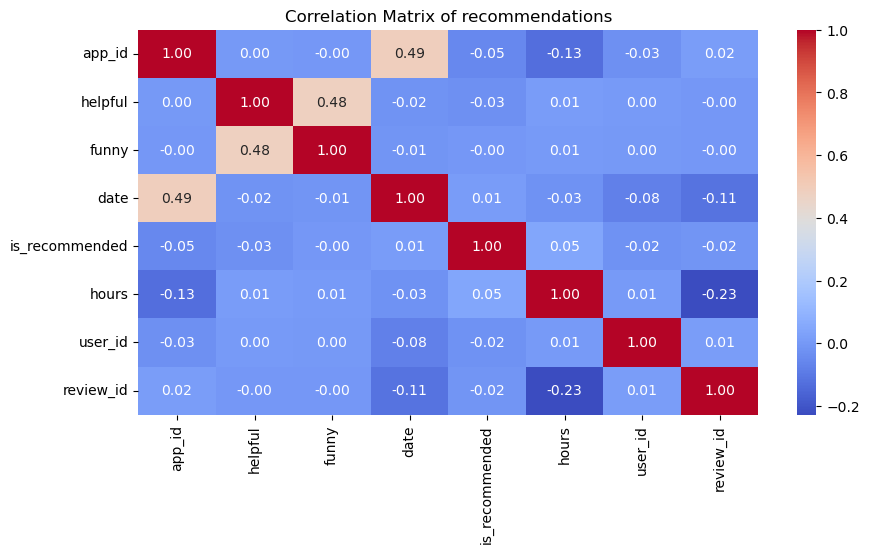

In [35]:
# correlation matrix for recommendations
correlation_matrix(recommendations, 'recommendations')

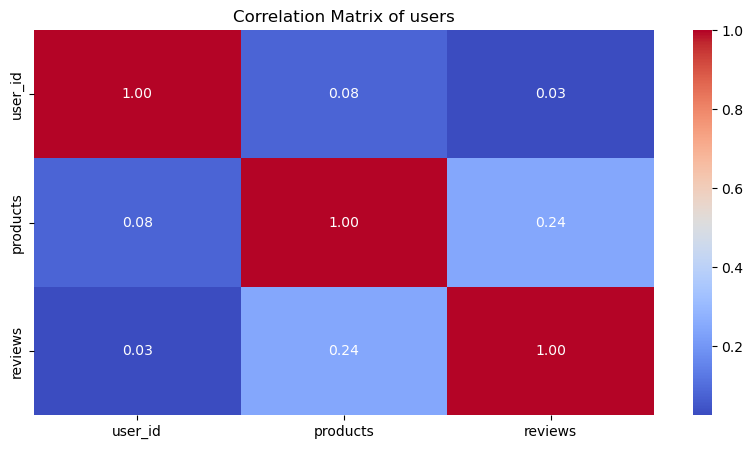

In [36]:
# correlation matrix for users
correlation_matrix(users, 'users')

**Review**

The correlations between the columns in the dataset aren't strong. But due to the business problem I chose specific columns to be ran on the collaborative and content filtering methods (more will be discussed later)

## Data Visualizations

In [37]:
# Function to plot 2 columns against each other
def plotter_compare(dataset, x, y, title):
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=x, y=y, data=dataset)
    plt.title(title)
    plt.show()

In [38]:
# Function to plot n numbers of columns against each other
def plotter_compare_multiple(dataset, columns, title):
    plt.figure(figsize=(10, 5))
    sns.pairplot(dataset[columns])
    plt.title(title)
    plt.show()

In [39]:
# Function to plot the distribution of the dataset
def plotter(dataset, column):
    plt.figure(figsize=(10, 5))
    sns.histplot(data=dataset, x=column, bins=20, kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

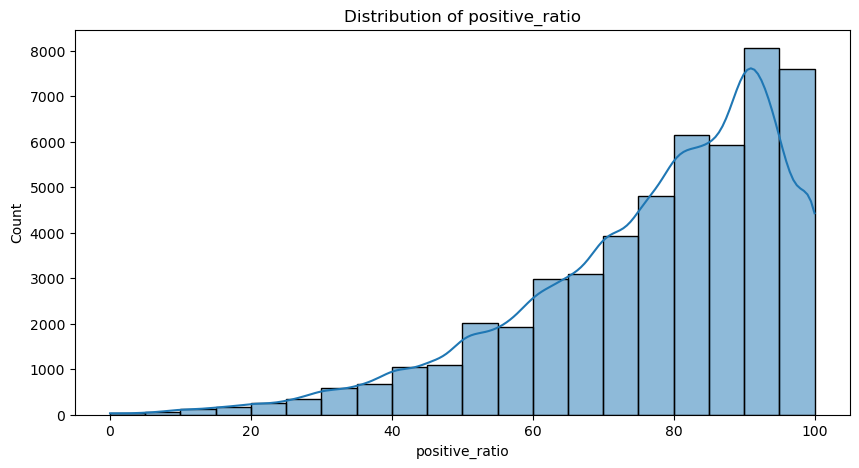

In [40]:
plotter(games, 'positive_ratio')

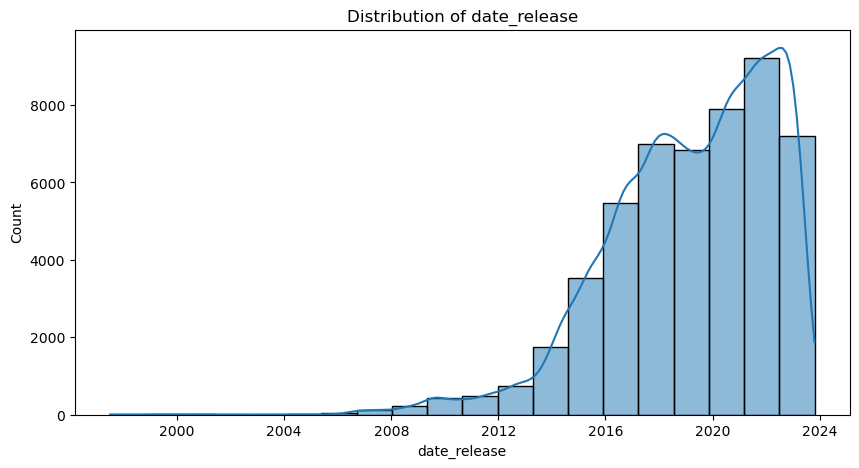

In [41]:
plotter(games, 'date_release')

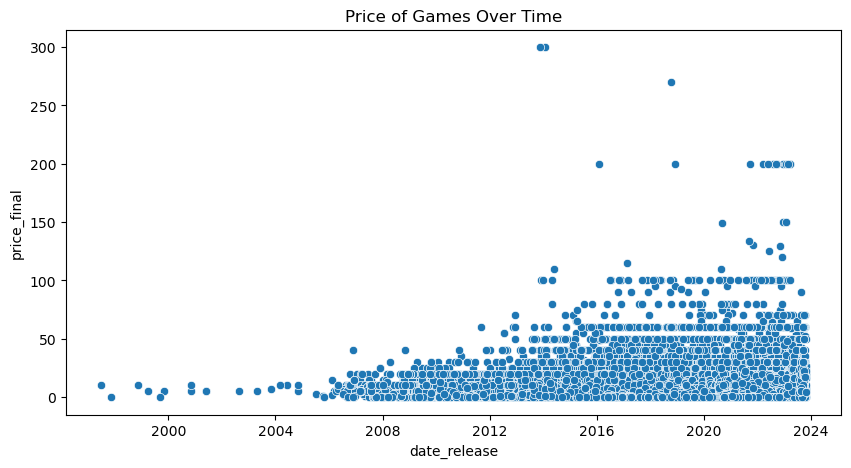

In [42]:
plotter_compare(games, 'date_release', 'price_final', 'Price of Games Over Time')

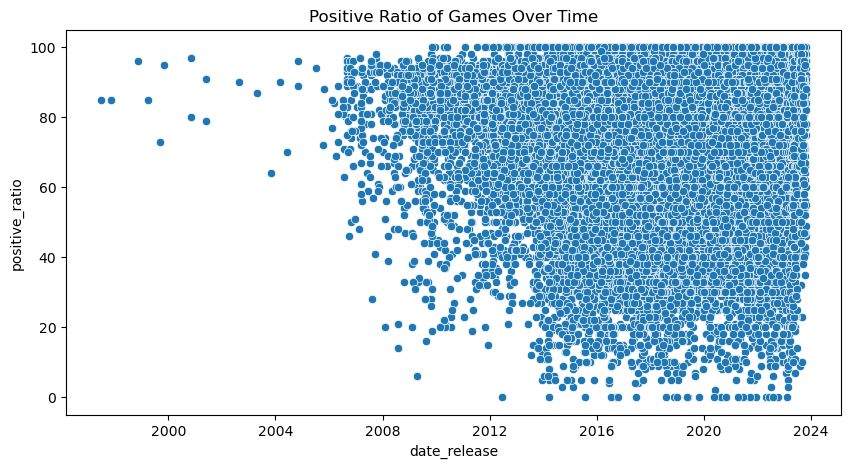

In [43]:
plotter_compare(games, 'date_release', 'positive_ratio', 'Positive Ratio of Games Over Time')

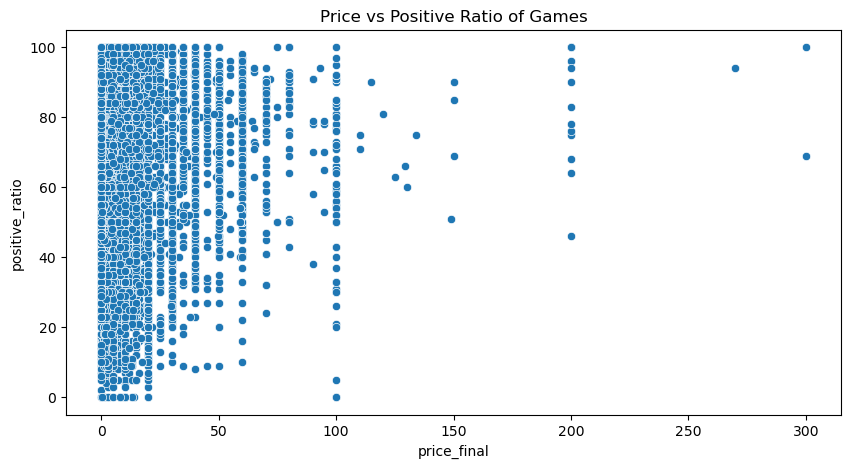

In [44]:
plotter_compare(games, 'price_final', 'positive_ratio', 'Price vs Positive Ratio of Games')

<Figure size 1000x500 with 0 Axes>

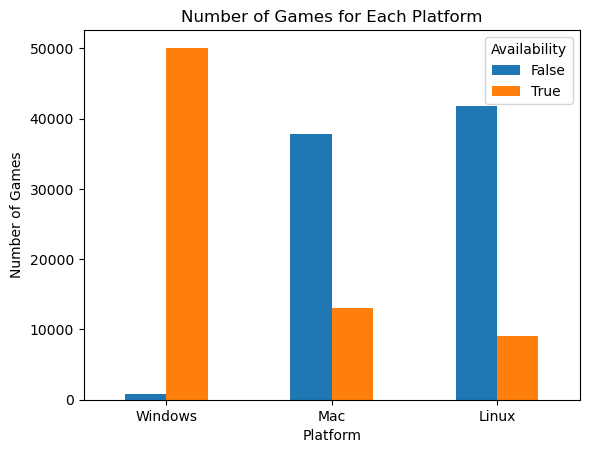

In [45]:
count_win = games['win'].value_counts()
count_mac = games['mac'].value_counts()
count_linux = games['linux'].value_counts()

# Combine the counts into a single DataFrame
platform_counts = pd.DataFrame({
    'Windows': count_win,
    'Mac': count_mac,
    'Linux': count_linux
}).transpose()

# Plot the combined bar plot
plt.figure(figsize=(10, 5))
platform_counts.plot(kind='bar')
plt.title('Number of Games for Each Platform')
plt.xlabel('Platform')
plt.ylabel('Number of Games')
plt.xticks(rotation=0)
plt.legend(title='Availability')
plt.show()


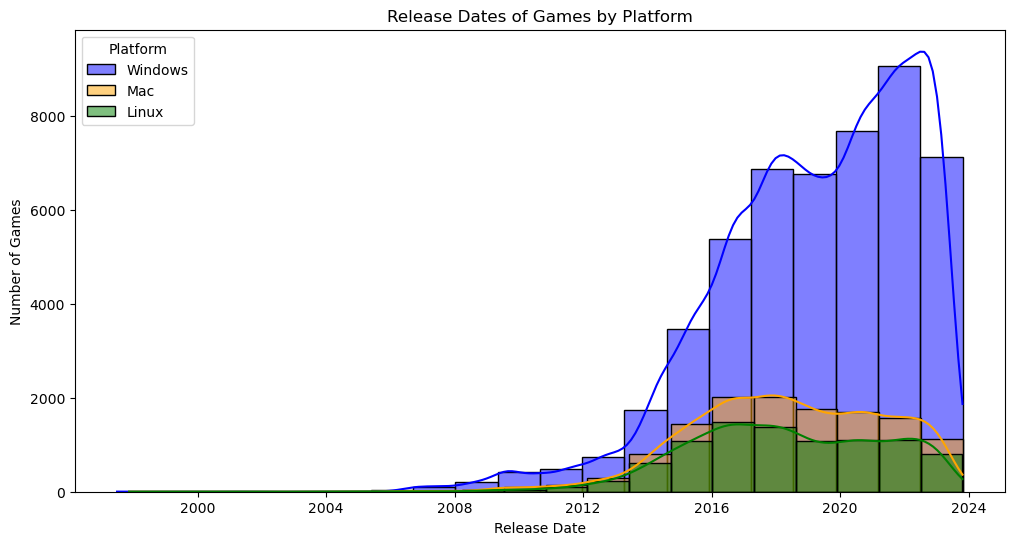

In [46]:
plt.figure(figsize=(12, 6))

# Windows
sns.histplot(data=games[games['win'] == True], x='date_release', kde=True, color='blue', bins=20, label='Windows', alpha=0.5)
# Mac
sns.histplot(data=games[games['mac'] == True], x='date_release', kde=True, color='orange', bins=20, label='Mac', alpha=0.5)
# Linux
sns.histplot(data=games[games['linux'] == True], x='date_release', kde=True, color='green', bins=20, label='Linux', alpha=0.5)

plt.title('Release Dates of Games by Platform')
plt.xlabel('Release Date')
plt.ylabel('Number of Games')
plt.legend(title='Platform')
plt.show()

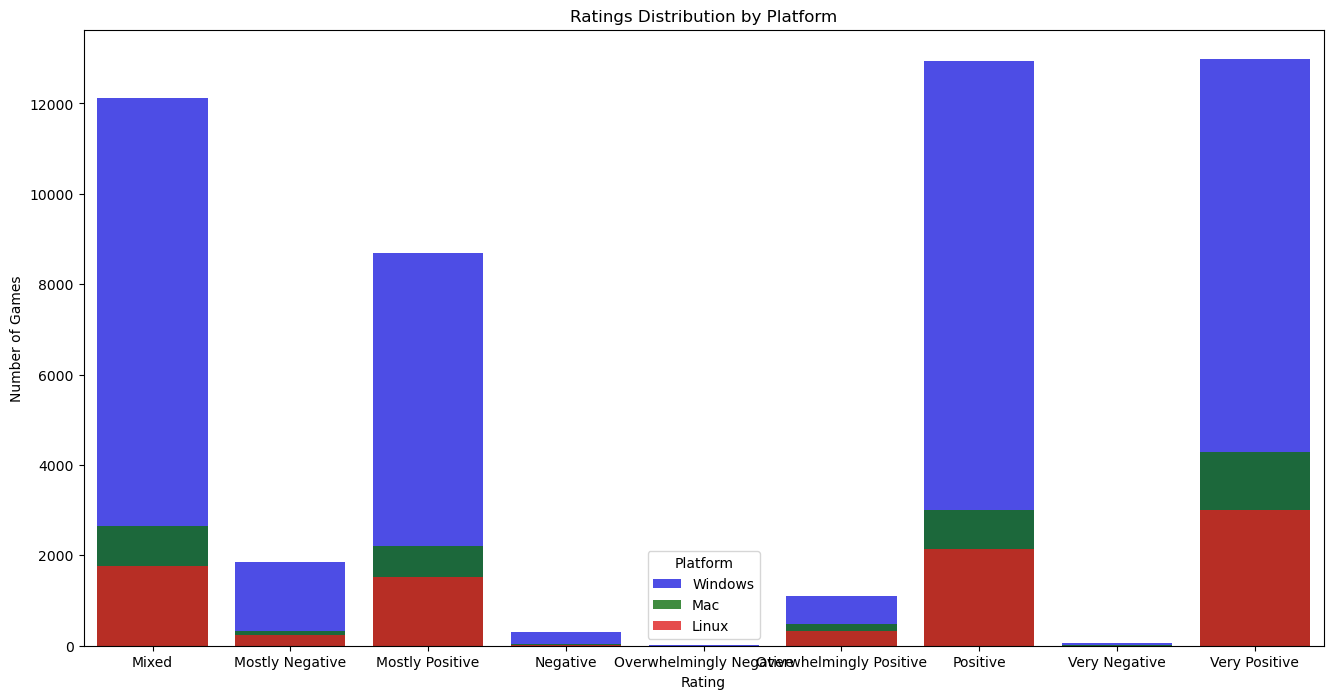

In [47]:
# Create separate count plots for each platform and combine them
plt.figure(figsize=(16, 8))

# Windows
count_win = games[games['win'] == True]['rating'].value_counts().sort_index()
sns.barplot(x=count_win.index, y=count_win.values, alpha=0.8, color='blue', label='Windows')

# Mac
count_mac = games[games['mac'] == True]['rating'].value_counts().sort_index()
sns.barplot(x=count_mac.index, y=count_mac.values, alpha=0.8, color='green', label='Mac')

# Linux
count_linux = games[games['linux'] == True]['rating'].value_counts().sort_index()
sns.barplot(x=count_linux.index, y=count_linux.values, alpha=0.8, color='red', label='Linux')

plt.title('Ratings Distribution by Platform')
plt.xlabel('Rating')
plt.ylabel('Number of Games')
plt.legend(title='Platform')
plt.show()

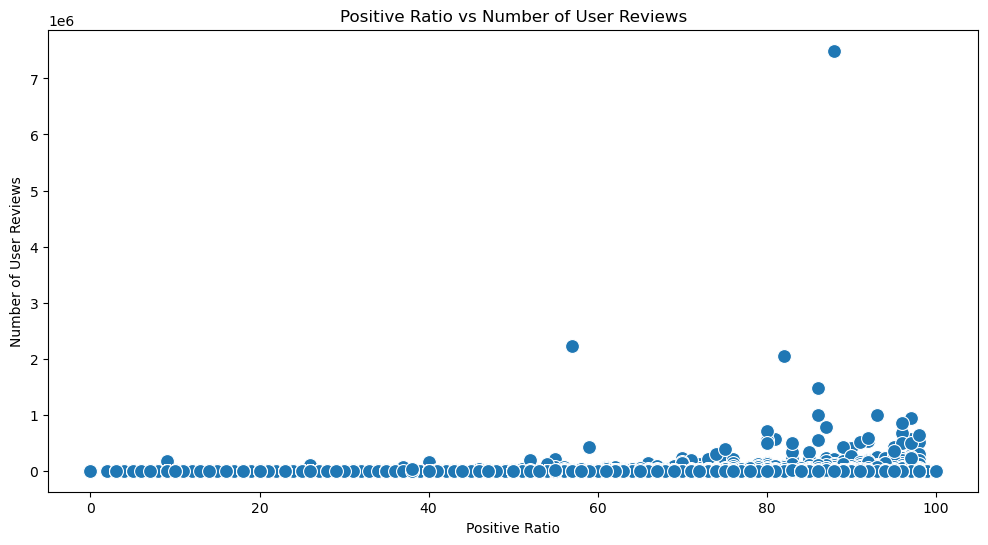

In [48]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='positive_ratio', y='user_reviews', data=games, s=100)
plt.title('Positive Ratio vs Number of User Reviews')
plt.xlabel('Positive Ratio')
plt.ylabel('Number of User Reviews')
plt.show()

**Review**

As you can see from the plots, there has been a drastic increase in the amount of games released from the year 2010 to present day. And the positive ratio of the "newer" games have a wide spread, with a concentration of around 7-8. The majority of games created were designed for windows users.

## Preprocessing the Datasets

In [49]:
# find the unique values for the rating column
games['rating'].unique()

array(['Very Positive', 'Positive', 'Mixed', 'Mostly Positive',
       'Overwhelmingly Positive', 'Negative', 'Mostly Negative',
       'Overwhelmingly Negative', 'Very Negative'], dtype=object)

Steam's ranking system

95 - 100 | 500+ reviews | positive | overwhelming

85 - 100 |  50+ reviews | positive | very

80 - 100 |   1+ reviews | positive

70 -  79 |   1+ reviews | positive | mostly

40 -  69 |   1+ reviews | mixed

20 -  39 |   1+ reviews | negative | mostly

 0 -  19 |   1+ reviews | negative

 0 -  19 |  50+ reviews | negative | very

 0 -  19 | 500+ reviews | negative | overwhelming
 

In [50]:
# converting boolean columns (win, mac, linux) to 0 or 1
games['win'] = games['win'].astype(int)
games['mac'] = games['mac'].astype(int)
games['linux'] = games['linux'].astype(int)
games['steam_deck'] = games['steam_deck'].astype(int)

In [51]:
# label encoding rating column
rating_mapping = {
    'Overwhelmingly Positive': 8,
    'Very Positive': 7,
    'Positive': 6,
    'Mostly Positive': 5,
    'Mixed': 4,
    'Mostly Negative': 3,
    'Negative': 2,
    'Very Negative': 1,
    'Overwhelmingly Negative': 0
}

# Map the 'rating' column to the defined integers
games['rating'] = games['rating'].map(rating_mapping)

# Convert the 'rating' column to int32
games['rating'] = games['rating'].astype('float32')

In [52]:
# create year column from the date_release column
games['year'] = games['date_release'].dt.year

In [53]:
# filter out games that were released before 2010
games = games[games['year'] >= 2010]

In [54]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50246 entries, 1 to 50871
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   app_id          50246 non-null  int32         
 1   title           50246 non-null  object        
 2   date_release    50246 non-null  datetime64[ns]
 3   win             50246 non-null  int32         
 4   mac             50246 non-null  int32         
 5   linux           50246 non-null  int32         
 6   rating          50246 non-null  float32       
 7   positive_ratio  50246 non-null  int32         
 8   user_reviews    50246 non-null  int32         
 9   price_final     50246 non-null  float32       
 10  price_original  50246 non-null  float32       
 11  discount        50246 non-null  float32       
 12  steam_deck      50246 non-null  int32         
 13  year            50246 non-null  int32         
dtypes: datetime64[ns](1), float32(4), int32(8), object(1)
memor

In [55]:
# converting the 'is_recommended' column to int
recommendations['is_recommended'] = recommendations['is_recommended'].astype(int)

In [56]:
# create year column from the date column
recommendations['year'] = recommendations['date'].dt.year

In [57]:
# filter out recommendations that were made before 2010
recommendations = recommendations[recommendations['date'].dt.year >= 2010]

In [58]:
recommendations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41154794 entries, 0 to 41154793
Data columns (total 9 columns):
 #   Column          Dtype         
---  ------          -----         
 0   app_id          int32         
 1   helpful         int32         
 2   funny           int32         
 3   date            datetime64[ns]
 4   is_recommended  int32         
 5   hours           float32       
 6   user_id         int32         
 7   review_id       int32         
 8   year            int32         
dtypes: datetime64[ns](1), float32(1), int32(7)
memory usage: 1.5 GB


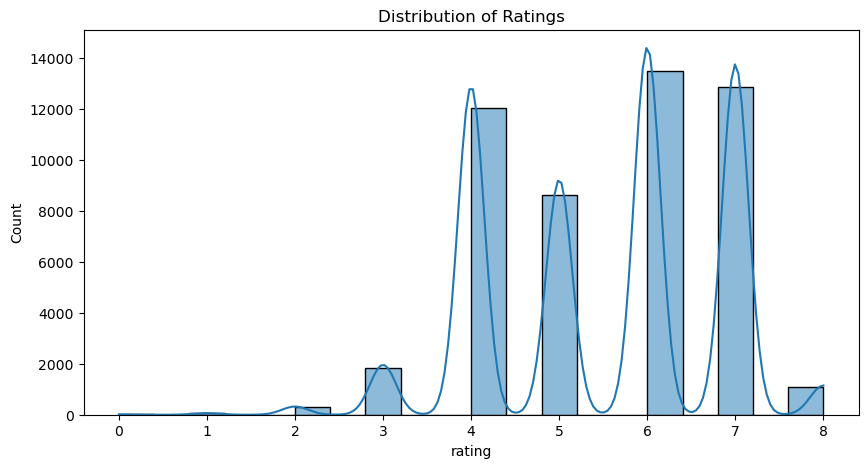

In [59]:
# plot the distribution of the ratings
plt.figure(figsize=(10, 5))
sns.histplot(data=games, x='rating', bins=20, kde=True)
plt.title('Distribution of Ratings')
plt.show()

**Review**

Here we did some simple preprocessing for our datasets. Later on there will be more specified preprocessing for collaborative and content based filters

### Collaborative Filtering using Surprise

Collaborative Filtering is a technique that can filter out items that a user might like on the basis of reactions by similar users. It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user.

Surprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data.

In [60]:
# Merge with custom suffixes
collaborative_filtering_df = pd.merge(recommendations, games, on='app_id')

In [61]:
# Assume we use positive_ratio as a proxy for rating (scale it appropriately)
collaborative_filtering_df['scaled_rating'] = collaborative_filtering_df['positive_ratio'] / 100

# Select relevant columns for the SVD model
collaborative_filtering_df = collaborative_filtering_df[['user_id', 'app_id', 'scaled_rating']]

# Display the prepared dataset
print(collaborative_filtering_df.head())

   user_id   app_id  scaled_rating
0    51580   975370           0.95
1     2586   304390           0.69
2   253880  1085660           0.81
3   259432   703080           0.90
4    23869   526870           0.97


In [62]:
# sample the collaborative_filtering_df dataset
_, sample_collaborative_filtering = sklearn_train_test_split(collaborative_filtering_df, test_size=0.0025, stratify=collaborative_filtering_df['scaled_rating'], random_state=42)

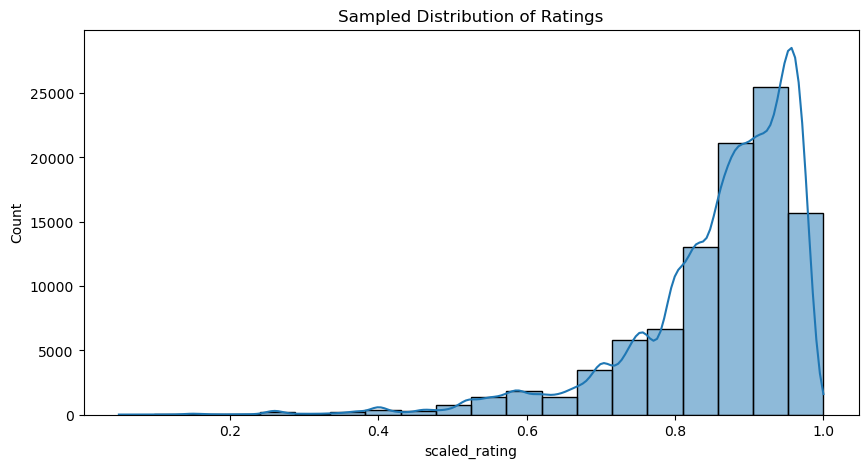

In [63]:
# plot the distribution of the ratings
plt.figure(figsize=(10, 5))
sns.histplot(data=sample_collaborative_filtering, x='scaled_rating', bins=20, kde=True)
plt.title('Sampled Distribution of Ratings')
plt.show()

In [64]:
# Check the distribution of the sampled data
print("Original data rating distribution:")
print(collaborative_filtering_df['scaled_rating'].value_counts(normalize=True))

print("Sampled data rating distribution:")
print(sample_collaborative_filtering['scaled_rating'].value_counts(normalize=True))

Original data rating distribution:
scaled_rating
0.95    0.068365
0.97    0.066451
0.96    0.063364
0.91    0.051105
0.94    0.049267
          ...   
0.08    0.000004
0.00    0.000003
0.07    0.000002
0.03    0.000001
0.04    0.000001
Name: proportion, Length: 99, dtype: float64
Sampled data rating distribution:
scaled_rating
0.95    0.068365
0.97    0.066451
0.96    0.063360
0.91    0.051100
0.94    0.049268
          ...   
0.12    0.000010
0.14    0.000010
0.19    0.000010
0.05    0.000010
0.09    0.000010
Name: proportion, Length: 93, dtype: float64


We have to ensure that the sampled data is representative of the original dataset, so that the results are not skewed

In [65]:
# number of recommendations
k = 10

# threshold for the number of reviews
threshold = 0.9

In [66]:
# build a collaborative filtering model using the Surprise library
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(sample_collaborative_filtering[['user_id', 'app_id', 'scaled_rating']], reader)
trainset, testset = surprise_train_test_split(data, test_size=0.2, random_state=42)

In [67]:
sample_collaborative_filtering

,user_id,app_id,scaled_rating
6522341,9306993,335300,0.85
509458,4650090,252490,0.87
6884559,9543924,12210,0.80
24628052,125959,391220,0.94
7518663,12487891,1237950,0.87
...,...,...,...
6203373,432331,1293830,0.89
4701332,12866590,394360,0.92
17336112,4497120,217200,0.94
24593758,7863956,880940,0.89


In [68]:
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  95707 

Number of items:  9203


Because there are more users than the number of items, we lean towards the user-user based filtering

User-user collaborative filtering is a recommendation method that uses a user's interactions with items to identify similar users and suggest items they might enjoy

In [69]:
# function to calculate precision and recall at k
def precision_recall_at_k(predictions, k, threshold):
    """Return precision and recall at k metrics for each user"""
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

### Baseline Model

The baseline model acts as a baseline to compare other models' performance to. The baseline model uses als as its method of determining the best k recommended games

In [70]:
baseline_model = BaselineOnly()
baseline_model.fit(trainset)

Estimating biases using als...


In [71]:
baseline_train_predictions = baseline_model.test(trainset.build_testset())
baseline_train_rmse = accuracy.rmse(baseline_train_predictions, verbose=False)
baseline_train_mae = accuracy.mae(baseline_train_predictions, verbose=False)

baseline_test_predictions = baseline_model.test(testset)
baseline_test_rmse = accuracy.rmse(baseline_test_predictions, verbose=False)
baseline_test_mae = accuracy.mae(baseline_test_predictions, verbose=False)

print(f'Baseline Train RMSE: {baseline_train_rmse}, Baseline Test RMSE: {baseline_test_rmse}')
print(f'Baseline Train MAE: {baseline_train_mae}, Baseline Test MAE: {baseline_test_mae}')

Baseline Train RMSE: 0.051687433516046745, Baseline Test RMSE: 0.05930760577128028
Baseline Train MAE: 0.024073123595177118, Baseline Test MAE: 0.027503328630533584


In [72]:
baseline_cv = cross_validate(baseline_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

print(f"Cross-Validation RMSE: {baseline_cv['test_rmse'].mean():.4f} ± {baseline_cv['test_rmse'].std():.4f}")
print(f"Cross-Validation MAE: {baseline_cv['test_mae'].mean():.4f} ± {baseline_cv['test_mae'].std():.4f}")

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0585  0.0605  0.0584  0.0598  0.0600  0.0594  0.0008  
MAE (testset)     0.0274  0.0277  0.0266  0.0274  0.0272  0.0273  0.0004  
Fit time          0.35    0.41    0.45    0.41    0.41    0.41    0.03    
Test time         0.07    0.07    0.07    0.06    0.06    0.06    0.01    
Cross-Validation RMSE: 0.0594 ± 0.0008
Cross-Validation MAE: 0.0273 ± 0.0004


In [73]:
baseline_train_precision, baseline_train_recall = precision_recall_at_k(baseline_train_predictions, k, threshold)
baseline_test_precision, baseline_test_recall = precision_recall_at_k(baseline_test_predictions, k, threshold)

# Average precision and recall for train and test sets
baseline_average_train_precision = sum(prec for prec in baseline_train_precision.values()) / len(baseline_train_precision)
baseline_average_train_recall = sum(rec for rec in baseline_train_recall.values()) / len(baseline_train_recall)

baseline_average_test_precision = sum(prec for prec in baseline_test_precision.values()) / len(baseline_test_precision)
baseline_average_test_recall = sum(rec for rec in baseline_test_recall.values()) / len(baseline_test_recall)

print(f'Baseline Average Train Precision@{k}: {baseline_average_train_precision}, Baseline Average Train Recall@{k}: {baseline_average_train_recall}')
print(f'Baseline Average Test Precision@{k}: {baseline_average_test_precision}, Baseline Average Test Recall@{k}: {baseline_average_test_recall}')

Baseline Average Train Precision@10: 1.0, Baseline Average Train Recall@10: 0.8850428907218997
Baseline Average Test Precision@10: 1.0, Baseline Average Test Recall@10: 0.8743127280201428


#### Singular Value Decomposition (SVD)

Singular value decomposition (SVD) is a method of representing a matrix as a series of linear approximations that expose the underlying meaning-structure of the matrix. The goal of SVD is to find the optimal set of factors that best predict the outcome

In [74]:
# Grid search for the best parameters
param_grid_svd = {
    'n_factors': [10, 20, 30, 40, 50],
    'n_epochs': [10, 20, 30, 40, 50],
    'lr_all': [0.005, 0.01, 0.02],
    'reg_all': [0.1, 0.2, 0.4]
}

In [75]:
gs_svd = GridSearchCV(SVD, param_grid_svd, measures=['rmse'], cv=3, n_jobs=-1)
gs_svd.fit(data)

In [76]:
best_svd = gs_svd.best_estimator['rmse']
best_svd_params = gs_svd.best_params['rmse']

print(f'Best SVD Parameters: {best_svd_params}')

Best SVD Parameters: {'n_factors': 10, 'n_epochs': 40, 'lr_all': 0.02, 'reg_all': 0.1}


In [77]:
cv_results = cross_validate(best_svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

print(f"Cross-Validation RMSE: {cv_results['test_rmse'].mean():.4f} ± {cv_results['test_rmse'].std():.4f}")
print(f"Cross-Validation MAE: {cv_results['test_mae'].mean():.4f} ± {cv_results['test_mae'].std():.4f}")

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0471  0.0456  0.0477  0.0477  0.0481  0.0472  0.0009  
MAE (testset)     0.0224  0.0218  0.0223  0.0222  0.0226  0.0222  0.0002  
Fit time          1.03    0.93    1.12    0.93    1.15    1.03    0.09    
Test time         0.06    0.07    0.06    0.07    0.07    0.07    0.00    
Cross-Validation RMSE: 0.0472 ± 0.0009
Cross-Validation MAE: 0.0222 ± 0.0002


In [78]:
best_svd.fit(trainset)

In [79]:
# Evaluate the model on the training set
svd_train_predictions = best_svd.test(trainset.build_testset())
svd_train_rmse = accuracy.rmse(svd_train_predictions, verbose=False)
svd_train_mae = accuracy.mae(svd_train_predictions, verbose=False)

# Evaluate the model on the test set
svd_test_predictions = best_svd.test(testset)
svd_test_rmse = accuracy.rmse(svd_test_predictions, verbose=False)
svd_test_mae = accuracy.mae(svd_test_predictions, verbose=False)

print(f'SVD Train RMSE: {svd_train_rmse}, SVD Test RMSE: {svd_test_rmse}')
print(f'SVD Train MAE: {svd_train_mae}, SVD Test MAE: {svd_test_mae}')

SVD Train RMSE: 0.012345736130641535, SVD Test RMSE: 0.04738765525684648
SVD Train MAE: 0.00782403659254485, SVD Test MAE: 0.022460066852947474


In [80]:
# Precision and recall at k for the SVD model
svd_train_precision, svd_train_recall = precision_recall_at_k(svd_train_predictions, k, threshold)
svd_test_precision, svd_test_recall = precision_recall_at_k(svd_test_predictions, k, threshold)

# Average precision and recall for train and test sets
svd_average_train_precision = sum(prec for prec in svd_train_precision.values()) / len(svd_train_precision)
svd_average_train_recall = sum(rec for rec in svd_train_recall.values()) / len(svd_train_recall)

svd_average_test_precision = sum(prec for prec in svd_test_precision.values()) / len(svd_test_precision)
svd_average_test_recall = sum(rec for rec in svd_test_recall.values()) / len(svd_test_recall)

print(f'SVD Average Train Precision@{k}: {svd_average_train_precision}, SVD Average Train Recall@{k}: {svd_average_train_recall}')
print(f'SVD Average Test Precision@{k}: {svd_average_test_precision}, SVD Average Test Recall@{k}: {svd_average_test_recall}')

SVD Average Train Precision@10: 0.9998742334747122, SVD Average Train Recall@10: 0.9578432775623845
SVD Average Test Precision@10: 0.9993833821489132, SVD Average Test Recall@10: 0.9281640203483891


#### K-Nearest Neighbors (KNN)

KNN is used to find the closest neighbours (users) based on a similarity metric. The recommendations are then made based on the preferences of these neighbours.

In [81]:
sample_collaborative_filtering

,user_id,app_id,scaled_rating
6522341,9306993,335300,0.85
509458,4650090,252490,0.87
6884559,9543924,12210,0.80
24628052,125959,391220,0.94
7518663,12487891,1237950,0.87
...,...,...,...
6203373,432331,1293830,0.89
4701332,12866590,394360,0.92
17336112,4497120,217200,0.94
24593758,7863956,880940,0.89


In [82]:
# take a sample of sample_collaborative_filtering for knn model
_, sample_knn = sklearn_train_test_split(sample_collaborative_filtering, test_size=0.3, random_state=42)

Here we have to take a sample of the dataset, due to insufficient memory in my computer

In [83]:
sample_knn.shape

(29314, 3)

In [84]:
# Check the distribution of the sampled data
print("sampled data data rating distribution:")
print(sample_collaborative_filtering['scaled_rating'].value_counts(normalize=True))

print("Sampled knn data rating distribution:")
print(sample_knn['scaled_rating'].value_counts(normalize=True))

sampled data data rating distribution:
scaled_rating
0.95    0.068365
0.97    0.066451
0.96    0.063360
0.91    0.051100
0.94    0.049268
          ...   
0.12    0.000010
0.14    0.000010
0.19    0.000010
0.05    0.000010
0.09    0.000010
Name: proportion, Length: 93, dtype: float64
Sampled knn data rating distribution:
scaled_rating
0.97    0.067613
0.95    0.067067
0.96    0.063758
0.91    0.051409
0.94    0.051102
          ...   
0.19    0.000034
0.20    0.000034
0.16    0.000034
0.39    0.000034
0.12    0.000034
Name: proportion, Length: 86, dtype: float64


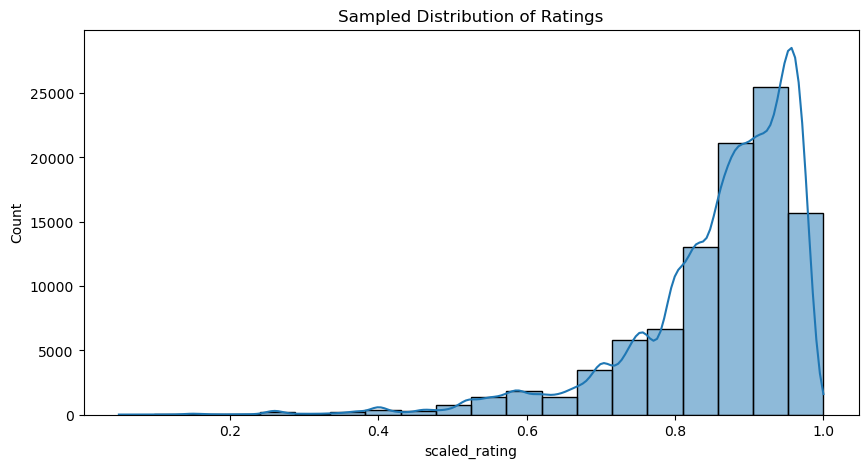

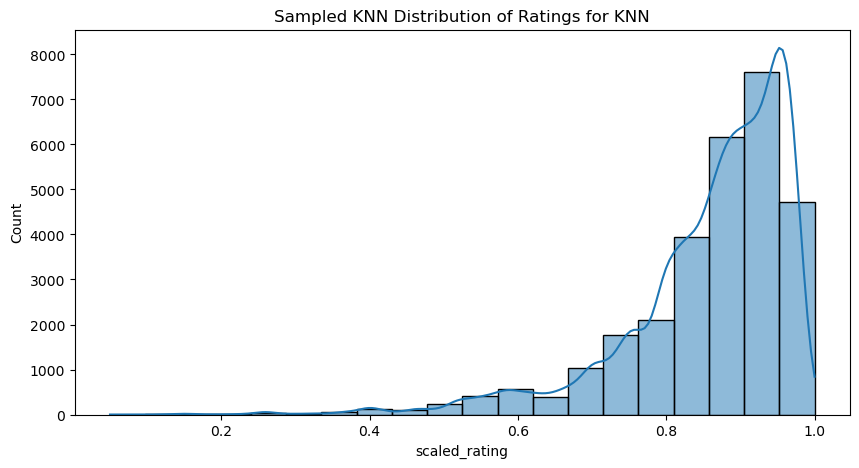

In [85]:
# plot the distribution of the ratings in sample_collaborative_filtering and sample_knn
plt.figure(figsize=(10, 5))
sns.histplot(data=sample_collaborative_filtering, x='scaled_rating', bins=20, kde=True)
plt.title('Sampled Distribution of Ratings')
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(data=sample_knn, x='scaled_rating', bins=20, kde=True)
plt.title('Sampled KNN Distribution of Ratings for KNN')
plt.show()

We can see here that the sampled distribution of ratings resembles the original (sample from svd and knn) dataset

In [86]:
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(sample_knn[['user_id', 'app_id', 'scaled_rating']], reader)
trainset, testset = surprise_train_test_split(data, test_size=0.2, random_state=42)

In [87]:
# Define the KNN model
param_grid = {
    'k': [80, 100, 120],
    'min_k': [8, 10, 12],
    'sim_options': {
        'name': ['cosine', 'pearson', 'msd'],
        'user_based': [True],
    }
}

In [88]:
gs_knn = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)

In [89]:
gs_knn.fit(data)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pea

In [90]:
best_knn = gs_knn.best_estimator['rmse']
best_knn_params = gs_knn.best_params['rmse']

print(best_knn_params)

{'k': 80, 'min_k': 8, 'sim_options': {'name': 'cosine', 'user_based': True}}


In [91]:
cv_results = cross_validate(best_knn, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

print(f"Cross-Validation RMSE: {cv_results['test_rmse'].mean():.4f} ± {cv_results['test_rmse'].std():.4f}")
print(f"Cross-Validation MAE: {cv_results['test_mae'].mean():.4f} ± {cv_results['test_mae'].std():.4f}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1154  0.1136  0.1124  0.1136  0.1130  0.1136  0.0010  
MAE (testset)     0.0843  0.0835  0.0822  0.0834  0.0835  0.0834  0.0007  
Fit time          4.57    8.30    11.01   7.14    11.05   8.41    2.45    
Test time         0.07    0.06    0.15    0.18    1.11    0.31    0.40    
Cross-Validation RMSE: 0.1136 ± 0.0010
Cross-Validation MAE: 0.0834 ± 0.0007


In [92]:
best_knn.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [93]:
# Evaluate the model on the training set
knn_train_predictions = best_knn.test(trainset.build_testset())
knn_train_rmse = accuracy.rmse(knn_train_predictions, verbose=False)
knn_train_mae = accuracy.mae(knn_train_predictions, verbose=False)

# Evaluate the model on the test set
knn_test_predictions = best_knn.test(testset)
knn_test_rmse = accuracy.rmse(knn_test_predictions, verbose=False)
knn_test_mae = accuracy.mae(knn_test_predictions, verbose=False)

print(f'KNN Train RMSE: {knn_train_rmse}, KNN Test RMSE: {knn_test_rmse}')
print(f'KNN Train MAE: {knn_train_mae}, KNN Test MAE: {knn_test_mae}')

KNN Train RMSE: 0.07490244074709015, KNN Test RMSE: 0.11437410306131507
KNN Train MAE: 0.03098022412429205, KNN Test MAE: 0.08320111880722435


In [94]:
svd_train_precision, svd_train_recall = precision_recall_at_k(svd_train_predictions, k, threshold)
svd_test_precision, svd_test_recall = precision_recall_at_k(svd_test_predictions, k, threshold)

# Average precision and recall for train and test sets
svd_average_train_precision = sum(prec for prec in svd_train_precision.values()) / len(svd_train_precision)
svd_average_train_recall = sum(rec for rec in svd_train_recall.values()) / len(svd_train_recall)

svd_average_test_precision = sum(prec for prec in svd_test_precision.values()) / len(svd_test_precision)
svd_average_test_recall = sum(rec for rec in svd_test_recall.values()) / len(svd_test_recall)

print(f'Average Train Precision@{k}: {svd_average_train_precision}, Average Train Recall@{k}: {svd_average_train_recall}')
print(f'Average Test Precision@{k}: {svd_average_test_precision}, Average Test Recall@{k}: {svd_average_test_recall}')

Average Train Precision@10: 0.9998742334747122, Average Train Recall@10: 0.9578432775623845
Average Test Precision@10: 0.9993833821489132, Average Test Recall@10: 0.9281640203483891


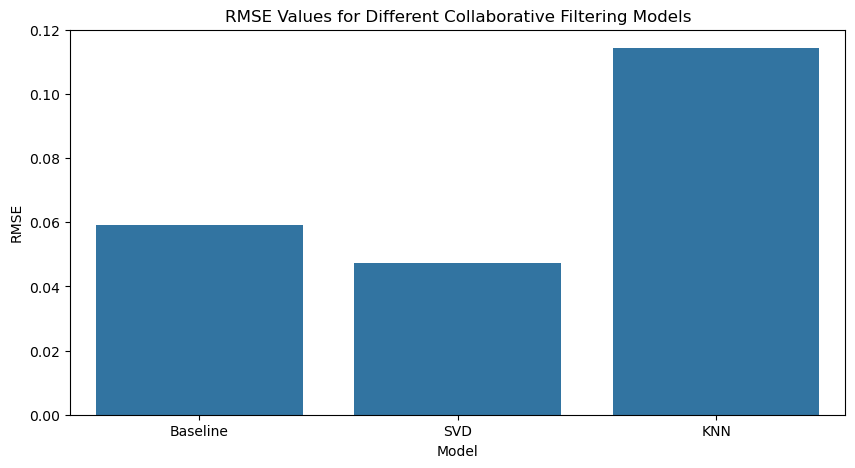

In [95]:
# graph all rsme value for all models
models = ['Baseline', 'SVD', 'KNN']
rmse_values = [baseline_test_rmse, svd_test_rmse, knn_test_rmse]

plt.figure(figsize=(10, 5))
sns.barplot(x=models, y=rmse_values)
plt.title('RMSE Values for Different Collaborative Filtering Models')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.show()

### Content Based Filtering

Content-based filtering uses item features to recommend other items similar to what the user likes, based on their previous actions or explicit feedback

Here we use nltk and tf-idf to vectorize the title, description, and tags. Then we compute the cosine similarity to find the most relevant games in the dataset

In [96]:
# change the 'tags' column from list to string
if type(games_metadata['tags'][0]) == tuple:
    games_metadata['tags'] = games_metadata['tags'].apply(lambda x: ' '.join(x))

In [97]:
# Check for empty strings
print("Empty descriptions:", (games_metadata['description'] == '').sum())
print("Empty tags:", (games_metadata['tags'] == '').sum())

Empty descriptions: 0
Empty tags: 0


In [98]:
content_based = pd.merge(games, games_metadata, on='app_id')

In [99]:
# Create the dataframe with user_id, app_id, title, and rating
user_ratings_data = pd.merge(recommendations, games, on='app_id')
user_ratings_data = user_ratings_data[['user_id', 'app_id', 'title', 'rating']]

In [100]:
# combine the 'title', 'description', and 'tags' columns into a single column
if 'combined_features' not in content_based.columns:
    content_based['combined_features'] = content_based.apply(lambda x: x['title'].lower() + ' ' + x['description'].lower() + ' ' + x['tags'].lower(), axis=1)

In [101]:
# only keep app_id, title, description, tags, and combined_features columns
content_based = content_based[['app_id', 'title', 'description', 'tags', 'combined_features']]
content_based['title'] = content_based['title'].str.lower()
content_based['description'] = content_based['description'].str.lower()
content_based['tags'] = content_based['tags'].str.lower()

In [102]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [103]:
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\d', ' ', text)  # Remove digits
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [106]:
# Apply preprocessing
content_based['combined_features'] = content_based['combined_features'].apply(preprocess_text)

In [107]:
content_based

,app_id,title,description,tags,combined_features
0,22364,brink: agents of change,no description,action,brink agent change description action
1,113020,monaco: what's yours is mine,monaco: what's yours is mine is a single playe...,co-op stealth indie heist local co-op strategy...,monaco mine monaco mine single player co op he...
2,226560,escape dead island,escape dead island is a survival-mystery adven...,zombies adventure survival action third person...,escape dead island escape dead island survival...
3,249050,dungeon of the endless™,dungeon of the endless is a rogue-like dungeon...,roguelike strategy tower defense pixel graphic...,dungeon endless dungeon endless rogue like dun...
4,250180,metal slug 3,"“metal slug 3”, the masterpiece in snk’s emble...",arcade classic action co-op side scroller retr...,metal slug metal slug masterpiece snk emblemat...
...,...,...,...,...,...
50241,2296380,i expect you to die 3: cog in the machine,no description,no tags,expect die cog machine description tag
50242,1272080,payday 3,no description,no tags,payday description tag
50243,1402110,eternights,no description,no tags,eternights description tag
50244,2272250,forgive me father 2,embark on a journey into the darkest nightmare...,early access fps action retro first-person lov...,forgive father embark journey darkest nightmar...


In [108]:
# Splitting the data into train and test sets
train_df, test_df = sklearn_train_test_split(content_based, test_size=0.2, random_state=42)

In [109]:
# Vectorize the combined_features if it's already prepared
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_train_matrix = tfidf_vectorizer.fit_transform(train_df['combined_features'])
tfidf_test_matrix = tfidf_vectorizer.transform(test_df['combined_features'])

In [110]:
def batch_cosine_similarity(tfidf_test_matrix, tfidf_train_matrix, batch_size=10):
    cosine_sim_batches = []
    num_batches = int(np.ceil(tfidf_test_matrix.shape[0] / batch_size))

    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, tfidf_test_matrix.shape[0])
        test_batch = tfidf_test_matrix[start_idx:end_idx]
        cosine_sim_batch = cosine_similarity(test_batch, tfidf_train_matrix)
        cosine_sim_batches.append(cosine_sim_batch)
    
    cosine_sim_test = np.vstack(cosine_sim_batches)
    return cosine_sim_test

In [111]:
# Calculate cosine similarity in batches
cosine_sim_train = batch_cosine_similarity(tfidf_train_matrix, tfidf_train_matrix)
cosine_sim_test = batch_cosine_similarity(tfidf_test_matrix, tfidf_train_matrix)

I need to batch the cosine similarity metric, due to insufficient memory

In [112]:
def get_recommendations(title, cosine_sim, data, k=10):
    # Get the index of the game that matches the title
    idx = data[data['title'] == title].index[0]
    
    # Ensure idx is within bounds of the cosine similarity matrix
    if idx >= cosine_sim.shape[0]:
        raise IndexError(f"Index {idx} is out of bounds for axis 0 with size {cosine_sim.shape[0]}")
    
    # Get the pairwise similarity scores of all games with that game
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the games based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the k most similar games
    sim_scores = sim_scores[1:k+1]
    
    # Get the game indices
    game_indices = [i[0] for i in sim_scores]
    
    # Return the top k most similar games
    return data.iloc[game_indices]

In [113]:
# Define relevance criteria: games with at least one matching tag are considered relevant
def is_relevant(test_tags, recommended_tags):
    test_set = set(test_tags.split())
    recommended_set = set(recommended_tags.split())
    return len(test_set & recommended_set) > 0

# Function to compute actual similarity
def actual_similarity(test_tags, recommended_tags):
    test_set = set(test_tags.split())
    recommended_set = set(recommended_tags.split())
    return len(test_set & recommended_set) / len(test_set | recommended_set)

# Function to evaluate the model
def evaluate_model(data_df, distance_metric, content_based, train_df, k=10):
    precision_scores = []
    recall_scores = []
    f1_scores = []
    rmse_scores = []
    mae_scores = []

    for test_idx in range(len(data_df)):
        row = data_df.iloc[test_idx]
        test_tags = row['tags']
        
        try:
            recommendations = get_recommendations(row['title'], distance_metric, content_based, k)
        except IndexError:
            continue
        
        if recommendations.empty:
            continue
        
        relevant_count = sum(is_relevant(test_tags, rec_tags) for rec_tags in recommendations['tags'])
        
        precision = relevant_count / k
        recall = relevant_count / len(test_tags.split())
        
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0)

        # Compute RMSE and MAE
        predicted_scores = []
        actual_scores = []
        for rec_title in recommendations['title']:
            train_indices = train_df[train_df['title'] == rec_title].index
            if not train_indices.empty:
                train_idx = train_indices[0]
                if train_idx < distance_metric.shape[1]:
                    predicted_scores.append(distance_metric[test_idx, train_idx])
                    actual_scores.append(actual_similarity(test_tags, recommendations[recommendations['title'] == rec_title]['tags'].values[0]))
        
        if predicted_scores and actual_scores:
            rmse_scores.append(mean_squared_error(actual_scores, predicted_scores, squared=False))
            mae_scores.append(mean_absolute_error(actual_scores, predicted_scores))
    
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)
    avg_rmse = np.mean(rmse_scores)
    avg_mae = np.mean(mae_scores)
    
    return avg_precision, avg_recall, avg_f1, avg_rmse, avg_mae

In [114]:
# Evaluate the model on training set
train_precision, train_recall, train_f1, train_rmse, train_mae = evaluate_model(train_df, cosine_sim_train, train_df, train_df)

# Evaluate the model on test set
test_precision, test_recall, test_f1, test_rmse, test_mae = evaluate_model(test_df, cosine_sim_test, content_based, train_df)

# Print the results for training set
print(f"Train Precision at {k}: {train_precision:.4f}, Test Precision at {k}: {test_precision:.4f}")
print(f"Train Recall at {k}: {train_recall:.4f}, Test Recall at {k}: {test_recall:.4f}")
print(f"Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}")
print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")

Train Precision at 10: 0.7195, Test Precision at 10: 0.7328
Train Recall at 10: 0.9104, Test Recall at 10: 0.8901
Train F1 Score: 0.6400, Test F1 Score: 0.6229
Train RMSE: 0.0844, Test RMSE: 0.0893
Train MAE: 0.0682, Test MAE: 0.0671


## Conclusions

Model to Choose: Singluar Value Decomposition (SVD)
- Best main metric: RMSE
- All other metrics scored well
- Was able to run the most number of rows (more variability)

In [116]:
# save the model
joblib.dump(best_svd, '../models/svd_model.pkl')

['../models/svd_model.pkl']

## Next Steps

1. Build more models to test on
2. Build a Hybrid model
3. Deployment for real users to use